# Credit Card Fraud Data Wrangling and EDA

# Load dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

sns.set_style("whitegrid")

In [2]:
data = pd.read_csv('CreditCardFraud.csv')
data.shape

(786363, 29)

### 1. Perform preliminary data quality checks, such as identifying duplicated columns and columns with entirely missing data. Determine how to manage these issues and justify your approach for handling them.

In [3]:
# Check for duplicated columns
duplicated_columns = data.columns[data.columns.duplicated()]
print("The duplicated_columns are :", duplicated_columns.shape[0])
# Check for columns with entirely missing data
missing_data_columns = data.columns[data.isnull().all()]
print("The columns with entirely missing data are :" + ", ".join(missing_data_columns))

The duplicated_columns are : 0
The columns with entirely missing data are :echoBuffer, merchantCity, merchantState, merchantZip, posOnPremises, recurringAuthInd


In [4]:
duplicated_columns.shape[0]

0

In [5]:
# Remove duplicated columns
data = data.drop(columns = duplicated_columns)

# Remove columns with entirely missing data
data = data.drop(columns = missing_data_columns)

In [6]:
data.shape

(786363, 23)

### 2. Pay close attention to outliers in numerical variables. Describe the methods you use for detecting outliers and explain your chosen approach for handling them. Justify your decisions and explain the potential impact of outliers on the analysis.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  float64
 10  posConditionCode          785954 non-null  float64
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [8]:
data.select_dtypes(include=['int64', 'float64']).columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionAmount', 'posEntryMode', 'posConditionCode', 'cardCVV',
       'enteredCVV', 'cardLast4Digits', 'currentBalance'],
      dtype='object')

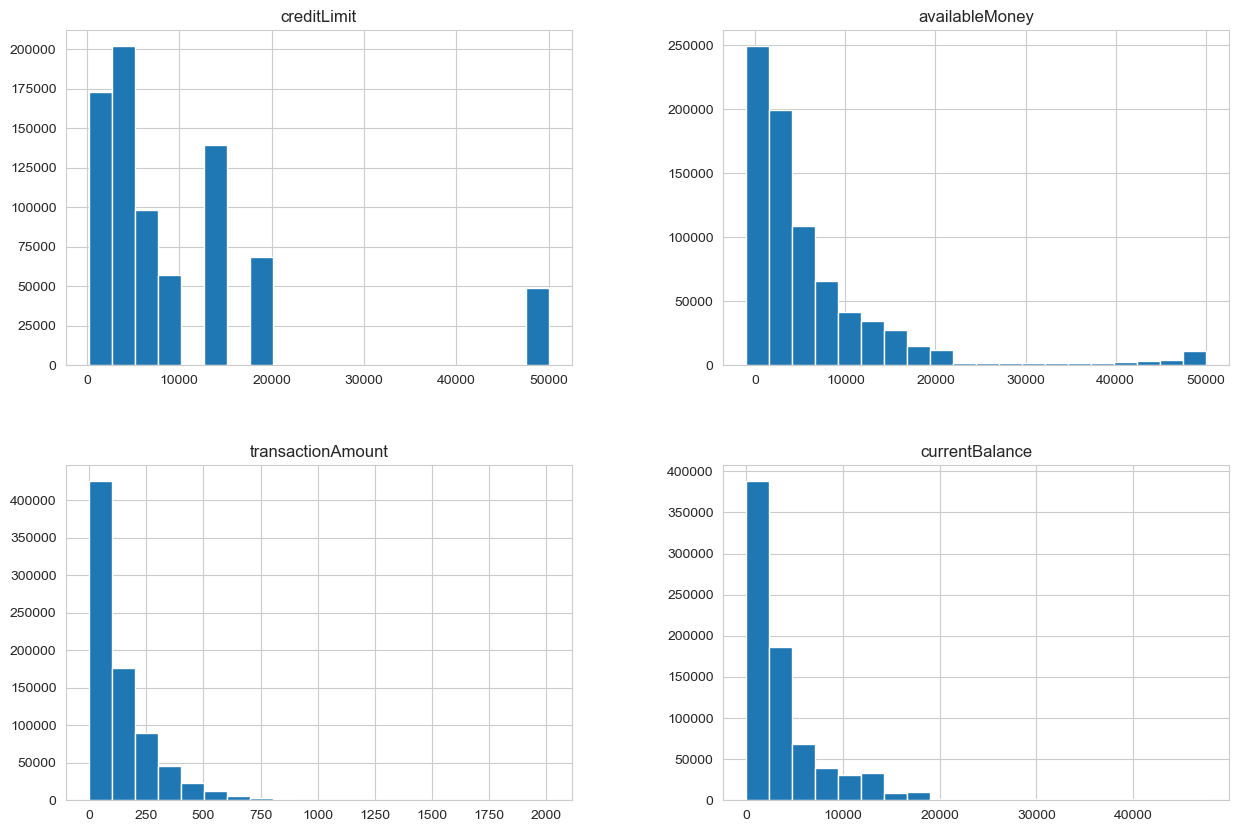

In [9]:
# Select numerical variables according to the context to the dataset
numerical_var = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']
data_num =  data[numerical_var]
data_num.hist(bins=20, figsize=(15, 10))
plt.show()

In [10]:
data_num.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


In [11]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   creditLimit        786363 non-null  float64
 1   availableMoney     786363 non-null  float64
 2   transactionAmount  786363 non-null  float64
 3   currentBalance     786363 non-null  float64
dtypes: float64(4)
memory usage: 24.0 MB


In [12]:
data_num.shape

(786363, 4)

The histograms for these selected four variables are right skewed, which suggest some outleirs. Due to skewness, we may use IQR.

Therefore, it is recommended to use the IQR method to handle the potential outliers, by computing the IQR value using the first and third quartiles and using a threshold of 1.5 × IQR to detect and handle the outliers 

In [13]:
def iqr(data, num_var):
    Q1 = data[num_var].quantile(0.25)
    Q3 = data[num_var].quantile(0.75)
    IQR = Q3 - Q1
    l_bound = Q1 - 1.5 * IQR
    u_bound = Q3 + 1.5 * IQR
    outliers = (data[num_var] < l_bound) | (data[num_var] > u_bound) # boolean
    return outliers

In [14]:
outliers = iqr(data, numerical_var)
outliers.sum() # number of outliers for 4 numerical variables

creditLimit          48781
availableMoney       58834
transactionAmount    40700
currentBalance       69603
dtype: int64

In [15]:
40700/len(data)*100

5.175726731801979

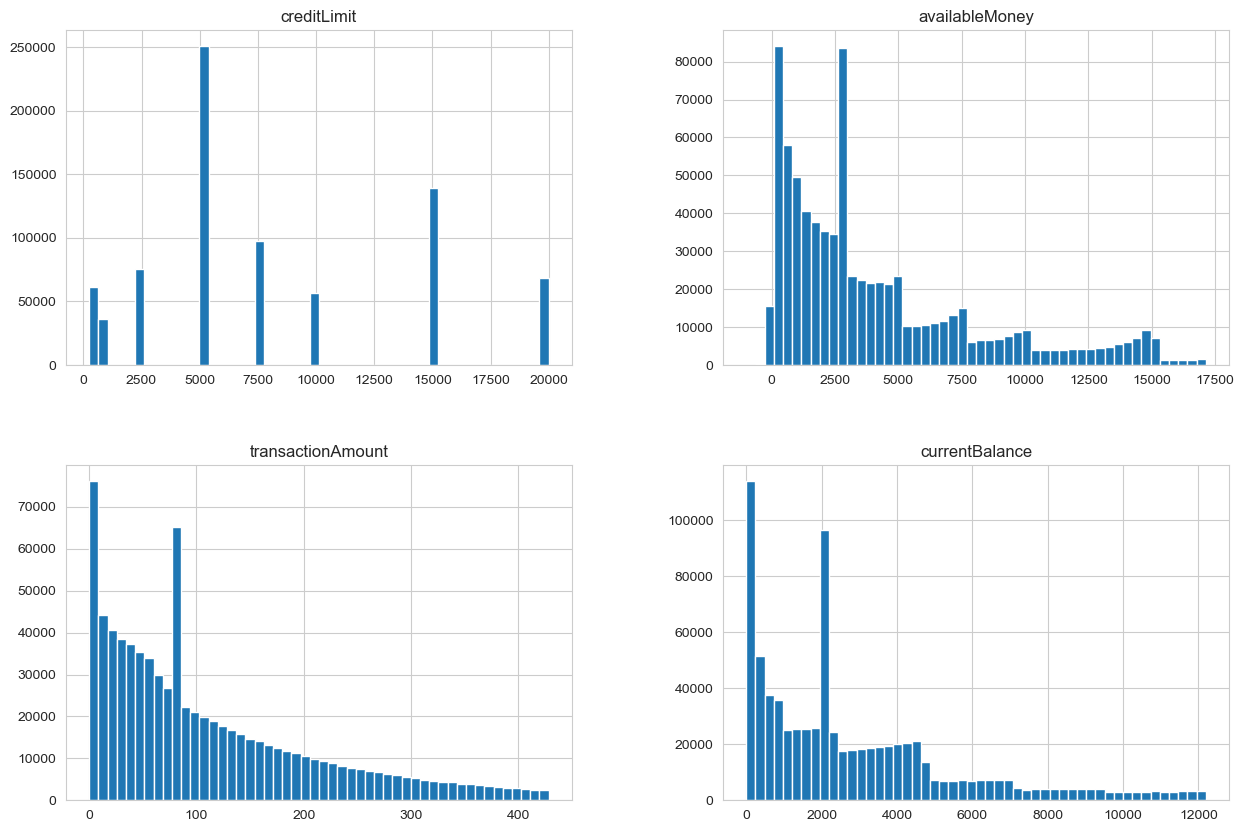

In [16]:
# Replace outliers with the median of the non-outlier data points
data_no_outliers = data_num.copy()
data_no_outliers[outliers] = np.nan
data_no_outliers = data_no_outliers.fillna(data_no_outliers.median()) # Median is better for skewness problems.
data_no_outliers.hist(bins=50, figsize=(15, 10))
plt.show()

The histogram looks more normal.

### 3. Identify columns with missing values and determine how to manage them. Justify your approach and reasoning for handling missing values in the dataset.

We have replaced all missing values in numerical columns with the median of that column.

In [17]:
data[numerical_var] = data_no_outliers

# Identify columns with missing values
miss_val_col = data.columns[data.isnull().any()] # columns below have missing value
miss_val_col

Index(['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'transactionType'],
      dtype='object')

In [18]:
data[miss_val_col].dtypes # these 3 colums are object 

acqCountry              object
merchantCountryCode     object
posEntryMode           float64
posConditionCode       float64
transactionType         object
dtype: object

In [19]:
print(data['acqCountry'].unique())
print(data['merchantCountryCode'].unique())
print(data['posEntryMode'].unique())
print(data['posConditionCode'].unique())
print(data['transactionType'].unique())

['US' nan 'CAN' 'MEX' 'PR']
['US' 'CAN' nan 'PR' 'MEX']
[ 2.  9.  5. 80. 90. nan]
[ 1.  8. 99. nan]
['PURCHASE' 'ADDRESS_VERIFICATION' 'REVERSAL' nan]


In [20]:
# calculate number of missing values for each column
data[miss_val_col].isna().sum()

acqCountry             4562
merchantCountryCode     724
posEntryMode           4054
posConditionCode        409
transactionType         698
dtype: int64

In [21]:
# proportion of missing number in the datasets
data[miss_val_col].isna().sum()/len(data)*100

acqCountry             0.580139
merchantCountryCode    0.092069
posEntryMode           0.515538
posConditionCode       0.052012
transactionType        0.088763
dtype: float64

In [22]:
fil = data[(data['acqCountry']!=data['merchantCountryCode'])
     & (~data['acqCountry'].isna()) & (~data['merchantCountryCode'].isna())]
fil.shape, fil['isFraud'].mean()*100

((67, 23), 0.0)

Moreover, we may consider dropping acqCountry as it appears about the same as merchantCountryCode. Also, merchantCountryCode has a higher mean fraud rate for missing values while having much fewer missing values.

In [23]:
def mean_fr(data, col):
    miss = data[col].isna()
    miss_fr = data[miss]['isFraud'].mean()*100
    non_miss_fr = data[~miss]['isFraud'].mean()*100
    print(f"The mean fraud rate for missing value in {col} is: {miss_fr:.2f}%")
    print(f"The mean fraud rate for non missing value in {col} is: {non_miss_fr:.2f}%")
    
for col in miss_val_col:
    mean_fr(data, col)


The mean fraud rate for missing value in acqCountry is: 3.27%
The mean fraud rate for non missing value in acqCountry is: 1.57%
The mean fraud rate for missing value in merchantCountryCode is: 11.33%
The mean fraud rate for non missing value in merchantCountryCode is: 1.57%
The mean fraud rate for missing value in posEntryMode is: 6.64%
The mean fraud rate for non missing value in posEntryMode is: 1.55%
The mean fraud rate for missing value in posConditionCode is: 5.38%
The mean fraud rate for non missing value in posConditionCode is: 1.58%
The mean fraud rate for missing value in transactionType is: 2.01%
The mean fraud rate for non missing value in transactionType is: 1.58%


In [24]:
miss = data['merchantCountryCode'].isna()
data[miss]['isFraud'].value_counts()
data[miss]['isFraud'].mean()*100

11.32596685082873

We see that all these varibles are categorical. And in each variable, the non-missing values tend to have a higher fraud rate compared with fraud rate. Therefore, We create a new category `unknown` to fill in missing values because it is a reasonable estimate for categorical variables. Also, deleting missing values can reduce the sample size and may lead to decreased accuracy and reliability of the model.

In [25]:
# create new categorical `unknown`
data['merchantCountryCode'].fillna('unknown', inplace=True)
data['posEntryMode'].fillna('unknown', inplace=True)
data['acqCountry'].fillna('unknown', inplace=True)
data['transactionType'].fillna('unknown', inplace=True)
data['posConditionCode'].fillna('unknown', inplace=True)

In [26]:
data[data['acqCountry']!=data['merchantCountryCode']].shape

(3911, 23)

In [27]:
# check for missing values
data.isnull().any()

accountNumber               False
customerId                  False
creditLimit                 False
availableMoney              False
transactionDateTime         False
transactionAmount           False
merchantName                False
acqCountry                  False
merchantCountryCode         False
posEntryMode                False
posConditionCode            False
merchantCategoryCode        False
currentExpDate              False
accountOpenDate             False
dateOfLastAddressChange     False
cardCVV                     False
enteredCVV                  False
cardLast4Digits             False
transactionType             False
currentBalance              False
cardPresent                 False
expirationDateKeyInMatch    False
isFraud                     False
dtype: bool

In [28]:
data.shape

(786363, 23)

In [29]:
data['merchantCountryCode'].value_counts()

US         778511
MEX          3143
CAN          2426
PR           1559
unknown       724
Name: merchantCountryCode, dtype: int64

### 4. Investigate the time variables in the dataset and address any potential issues that may arise when working with them. This may involve converting the variables to a suitable format, conducting additional cleaning, and/or extracting meaningful features to ensure consistency and usability in the analysis. Justify your approach and reasoning for handling time variables, explaining how your decisions enhance the overall data quality and interpretation.

In [30]:
data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,...,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


In [31]:
# Select time variables
time_col = np.array(["transactionDateTime", "accountOpenDate", "dateOfLastAddressChange"])
time_col
data_time = data[time_col]
data_time.head()

,transactionDateTime,accountOpenDate,dateOfLastAddressChange
0,2016-08-13T14:27:32,2015-03-14,2015-03-14
1,2016-10-11T05:05:54,2015-03-14,2015-03-14
2,2016-11-08T09:18:39,2015-03-14,2015-03-14
3,2016-12-10T02:14:50,2015-03-14,2015-03-14
4,2016-03-24T21:04:46,2015-08-06,2015-08-06


In [32]:
# 1.Convert to date_time formate 
df_time = data_time.copy()
df_time['transactionDateTime'] = pd.to_datetime(data_time['transactionDateTime'])
df_time['accountOpenDate'] = pd.to_datetime(data_time['accountOpenDate'])
df_time['dateOfLastAddressChange'] = pd.to_datetime(data_time['dateOfLastAddressChange'])


In [33]:
# 2. Check for any missing or irregular timestamps:
print(df_time.isnull().sum())

transactionDateTime        0
accountOpenDate            0
dateOfLastAddressChange    0
dtype: int64


In [34]:
# 3. extract some useful variabel
# days of the transaction since the account was opened
df_time['days_since_acc_open'] = (df_time['transactionDateTime'] - df_time['accountOpenDate']).dt.days
df_time.head()

,transactionDateTime,accountOpenDate,dateOfLastAddressChange,days_since_acc_open
0,2016-08-13 14:27:32,2015-03-14,2015-03-14,518
1,2016-10-11 05:05:54,2015-03-14,2015-03-14,577
2,2016-11-08 09:18:39,2015-03-14,2015-03-14,605
3,2016-12-10 02:14:50,2015-03-14,2015-03-14,637
4,2016-03-24 21:04:46,2015-08-06,2015-08-06,231


In [35]:
# 4. Check for inconsistency
# transactions that happened before the account was opened
incon_dates = df_time[(df_time['transactionDateTime'] < df_time['accountOpenDate']) ]
print("The number of transaction that is inconsistency is", incon_dates.shape[0])

The number of transaction that is inconsistency is 0


In [36]:
# 5. combine to the original dataset
data[time_col] = df_time[time_col]
data['days_since_acc_open'] = df_time['days_since_acc_open']
data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,days_since_acc_open
0,737265056,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,2.0,...,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False,518
1,737265056,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,9.0,...,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False,577
2,737265056,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,9.0,...,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,605
3,737265056,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,9.0,...,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,637
4,830329091,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,2.0,...,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False,231


### 5. Certain columns in the dataset may require special treatment during data wrangling due to their unique characteristics (e.g., cardCVV, enteredCVV, cardLast4Digits). Explore alternative methods for integrating these variables into your analysis, and document any decisions made during this stage.

In [37]:
cvv_col = ['cardCVV', 'enteredCVV', 'cardLast4Digits']
data[cvv_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   cardCVV          786363 non-null  int64
 1   enteredCVV       786363 non-null  int64
 2   cardLast4Digits  786363 non-null  int64
dtypes: int64(3)
memory usage: 18.0 MB


In [38]:
# 5.1 create new features that capture relevant information
# create a categorical variable 'cvv_math' that is (cardCVV == enteredCVV)
data['cvv_match'] = (data['cardCVV'] == data['enteredCVV']).astype(int)
data.groupby('cvv_match')['isFraud'].value_counts()

cvv_match  isFraud
0          False        6812
           True          203
1          False      767134
           True        12214
Name: isFraud, dtype: int64

In [39]:
data.groupby('cvv_match')['isFraud'].mean()*100

cvv_match
0    2.893799
1    1.567207
Name: isFraud, dtype: float64

This information could be relevant for detecting fraudulent transactions, as fraudsters might enter incorrect CVV codes. what's more, when cvv_match is 0, it has a higher fraud rate compared with cvv_match = 1.



In [40]:
data['posEntryMode'] = data['posEntryMode'].astype(str)
data['posConditionCode'] = data['posConditionCode'].astype(str)

### 6. Analyze the relationship between the columns cardCVV, enteredCVV, and cardLast4Digits and the target variable, isFraud, using an appropriate visualization (such as a grouped bar chart). Discuss the insights gained about the relationship between these variables and credit card fraud.

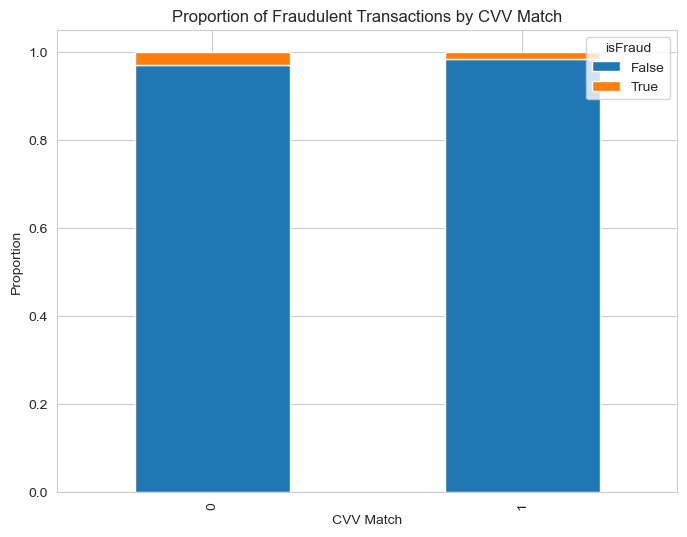

In [41]:
cf_counts = data.groupby(['cvv_match', 'isFraud']).size().reset_index(name='count')
cf_pivot = cf_counts.pivot(index='cvv_match', columns='isFraud', values='count')
# get the ratio for the matrix
fraud_prop = cf_pivot.apply(lambda x: x / x.sum(), axis=1)

# Create a grouped bar chart with the proportion of each combination
ax = fraud_prop.plot(kind='bar', stacked=True, figsize=(8, 6))
ax.set_xlabel('CVV Match')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of Fraudulent Transactions by CVV Match')
ax.legend(loc='upper right', title='isFraud')
plt.show()

In [42]:
fraud_prop

isFraud,False,True
cvv_match,,
0,0.971062,0.028938
1,0.984328,0.015672


"The grouped bar chart shows the proportion of fraudulent transactions by CVV Match, where the x-axis represents whether the CVV code entered matches the true CVV code, and the y-axis represents the proportion of transactions that are fraudulent within each `CVV_match` category. The blue color indicates fraudulent transactions and the red color indicates non-fraudulent transactions.

The table confirms the results of the grouped bar chart, indicating that the proportion of fraudulent transactions is higher when the CVV code does not match (0.028938) compared to when it does match (0.015672). In other words, transactions where the CVV code does not match have a higher probability of being fraudulent. This suggests that `CVV_match` could be a useful variable in predictive models for credit card fraud detection."







### 7. Visualize the distribution of `transactionAmount` using an appropriate plot, such as a histogram or density plot. Provide a brief analysis of the observed pattern and discuss any insights or trends you can infer from the visualization.

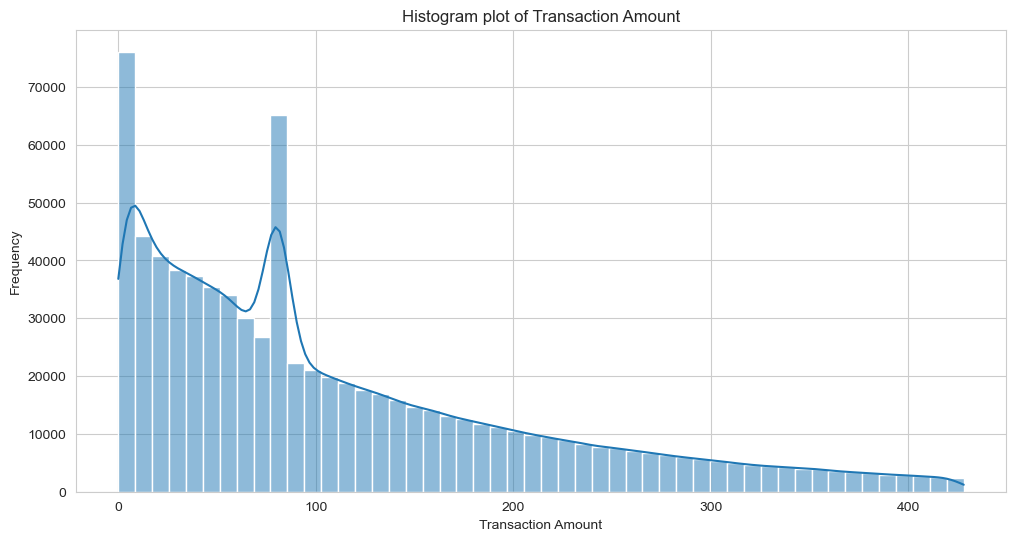

In [43]:
plt.figure(figsize=(12, 6))
sns.histplot(data['transactionAmount'], kde=True, bins=50)
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Histogram plot of Transaction Amount')
plt.show()

This historgram plot shows a right-skewed distribution, which means that small transaction amounts are more frequent than large transaction amounts. 

We could suspect that more fradulant transactions happen in the lower transaction amount because people may not perceive the small transaction amount and people tend to make more transaction for a small amount. What's more, it is safer for fradualer to make a small amount transaction.

### 8. Investigate the relationship between isFraud and categorical predictors, such as merchantCategoryCode, posEntryMode, transactionType, posConditionCode, and merchantCountryCode, by creating suitable visualizations like bar charts to display the fraud rate for each category. Describe the patterns you observe and their potential implications for creating a predictive model for fraudulent transactions.

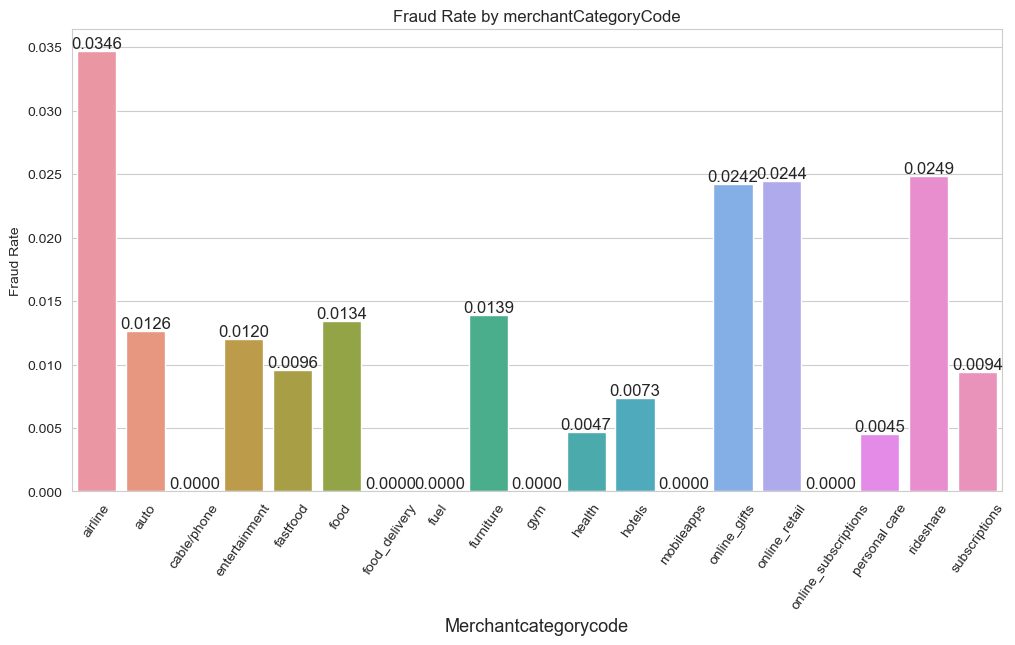

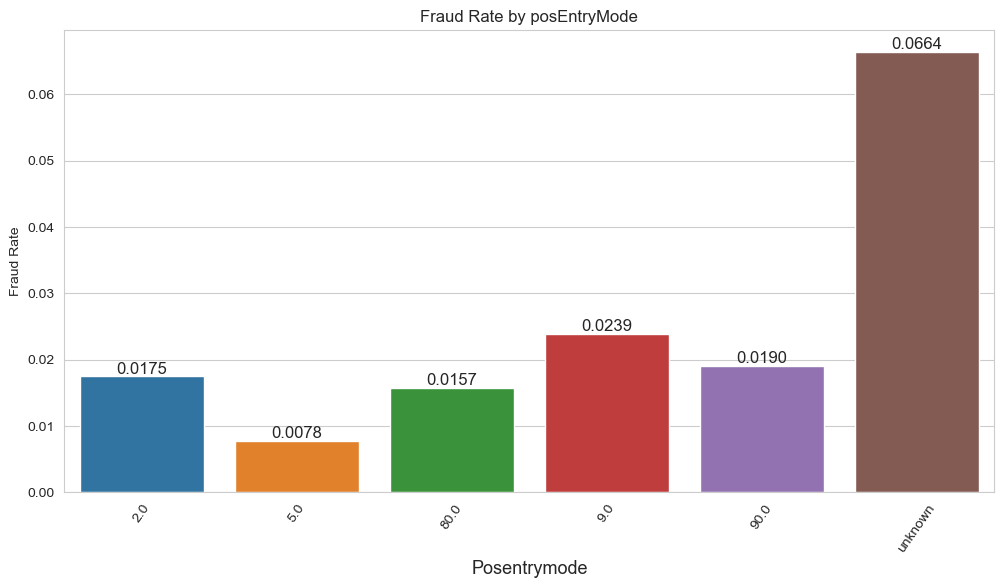

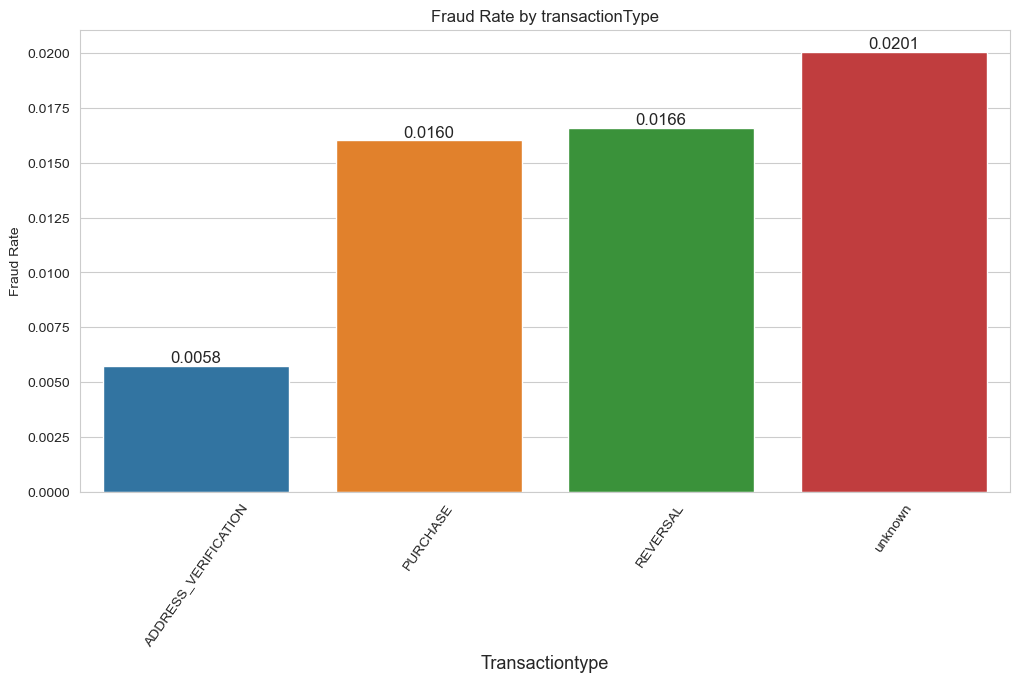

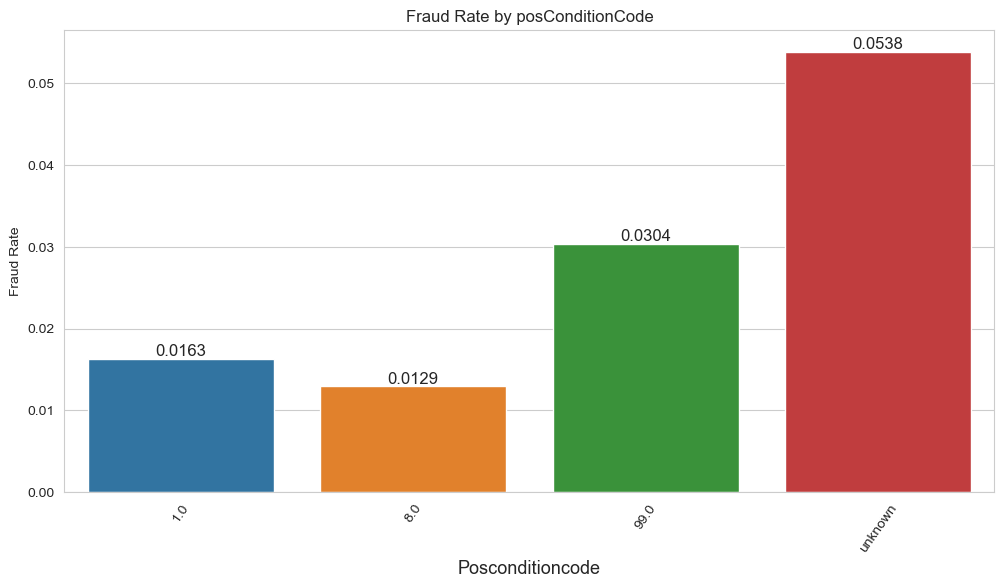

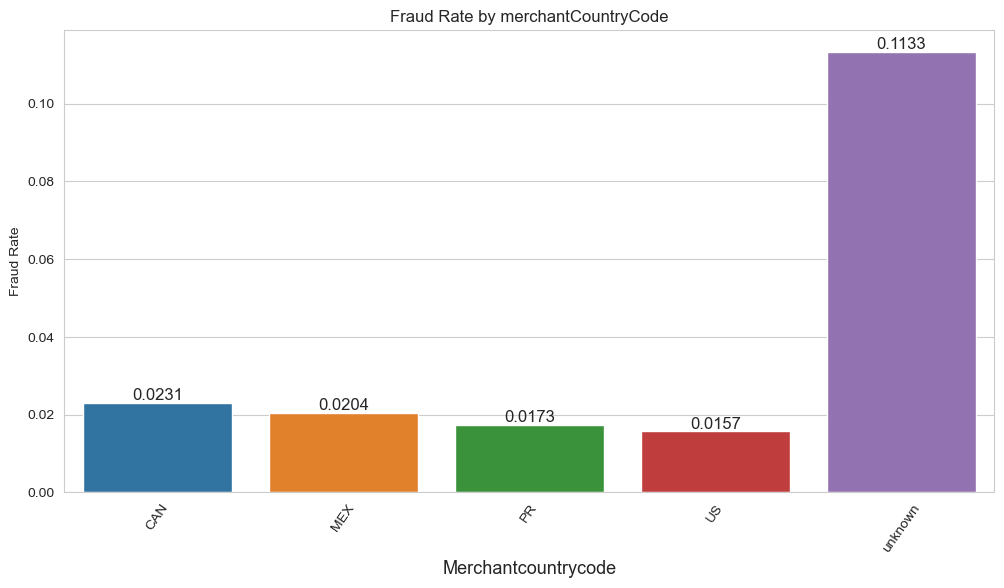

In [44]:
# create bar charts to detect the relationship between isFraud and each categorical predictor
cat_col = ['merchantCategoryCode', 'posEntryMode', 'transactionType', 'posConditionCode', 'merchantCountryCode']
def plot_fr(data, col):
    fraud_rate = data.groupby(col)['isFraud'].mean().reset_index(name='fraud_rate')
    plt.figure(figsize=(12, 6))
    sns.barplot(x=col, y='fraud_rate', data=fraud_rate)
    plt.ylabel('Fraud Rate')
    plt.xlabel(col.capitalize(), fontsize=13)
    plt.title(f'Fraud Rate by {col}')
    plt.xticks(rotation=55)
    # Add values to the barplot
    for i, v in enumerate(fraud_rate['fraud_rate']):
        plt.annotate(f'{v:.4f}', xy=(i, v), ha='center', va='bottom', fontsize=12)
    plt.show()

for col in cat_col:
     plot_fr(data, col)

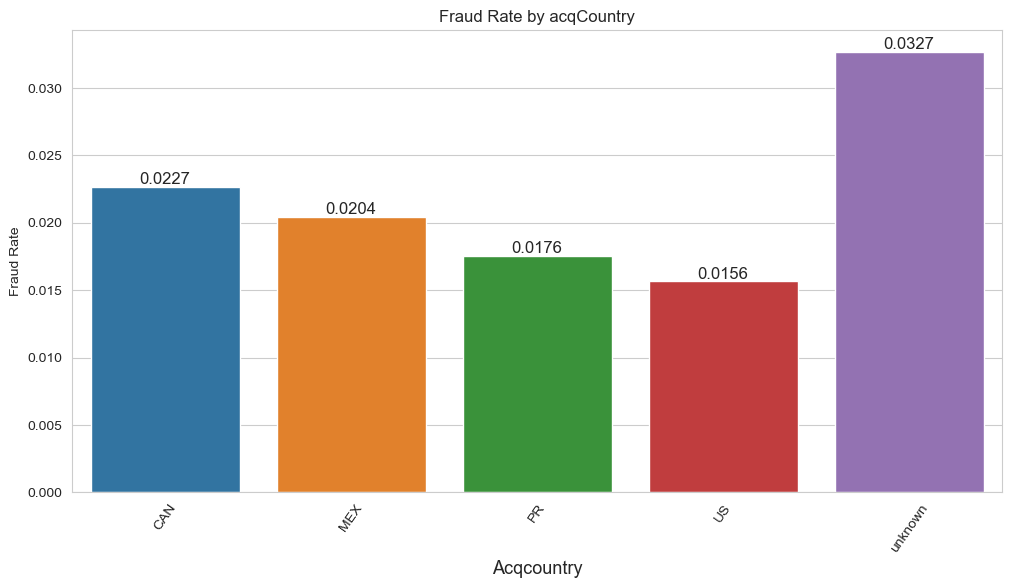

In [45]:
plot_fr(data, 'acqCountry')

### 9. Further explore the relationship between `isFraud ` and `transactionType` conditioned on `merchantCategoryCode` by generating a grouped bar chart or another suitable visualization to display the fraudulent rates by merchant category code and transaction type. Share any additional insights you have.

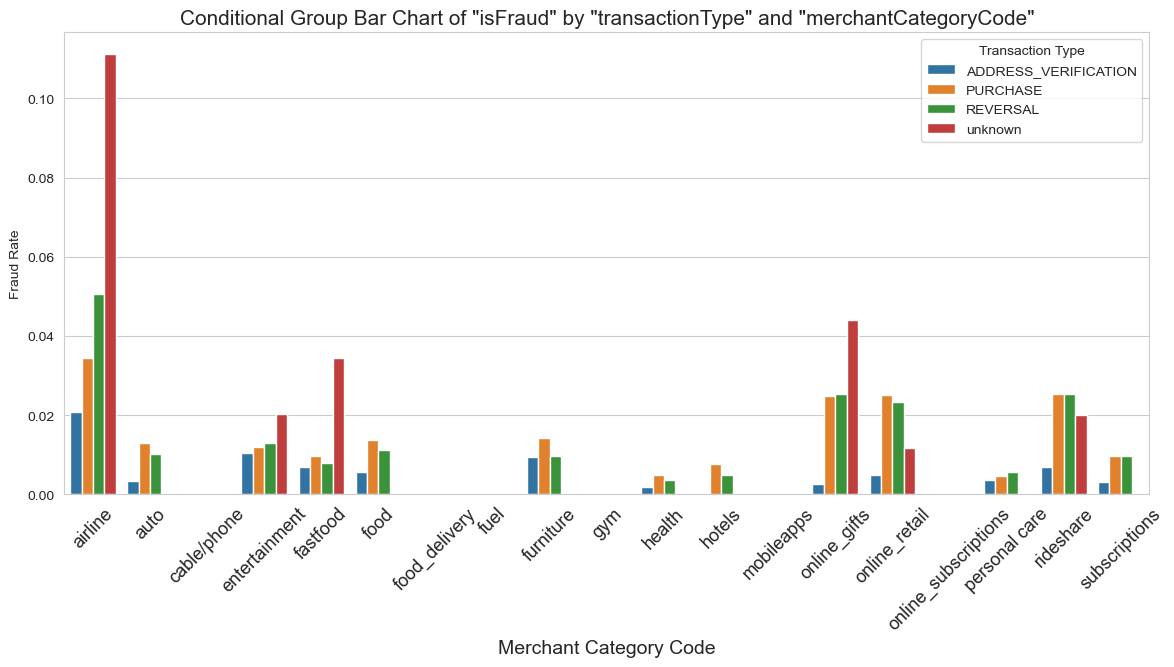

In [46]:
# Group by 'merchantCategoryCode' and 'transactionType'
df_mt = data.groupby(['merchantCategoryCode', 'transactionType'])['isFraud'].mean().reset_index(name='fraud_rate')

plt.figure(figsize=(14, 6))
sns.barplot(x='merchantCategoryCode', y='fraud_rate', hue='transactionType', data=df_mt)
plt.xlabel('Merchant Category Code', fontsize=14)
plt.ylabel('Fraud Rate')
plt.title('Conditional Group Bar Chart of "isFraud" by "transactionType" and "merchantCategoryCode"', fontsize=15)
plt.xticks(rotation=45, fontsize=13)
plt.legend(title='Transaction Type')
plt.show()


Apparently, within each merchant category code, there is a trend that "reversal" and "purchase" transaction types have a higher fraud rate than address_verification type, which indicates that the relationship between `transactionType` and `isFraud` may depend on `merchantCategoryCode`. Hence, we could add an interaction between `transactionType` and `merchantCategoryCode` for the predictive credit card fraud prediction, in order to improve the model performance with more information.

Also interaction between `transactionType` and `merchantCategoryCode` .

### 10. Construct conditional probability density plots (or other suitable visualizations) for the numerical variables in the dataset to help understand the relationships between these variables and the target variable, `isFraud`. Identify any patterns or trends suggesting a relationship between the numerical variables and fraudulent transactions.

In [47]:
print("We have numerical variables:",", ".join(numerical_var),'.')

We have numerical variables: creditLimit, availableMoney, transactionAmount, currentBalance .


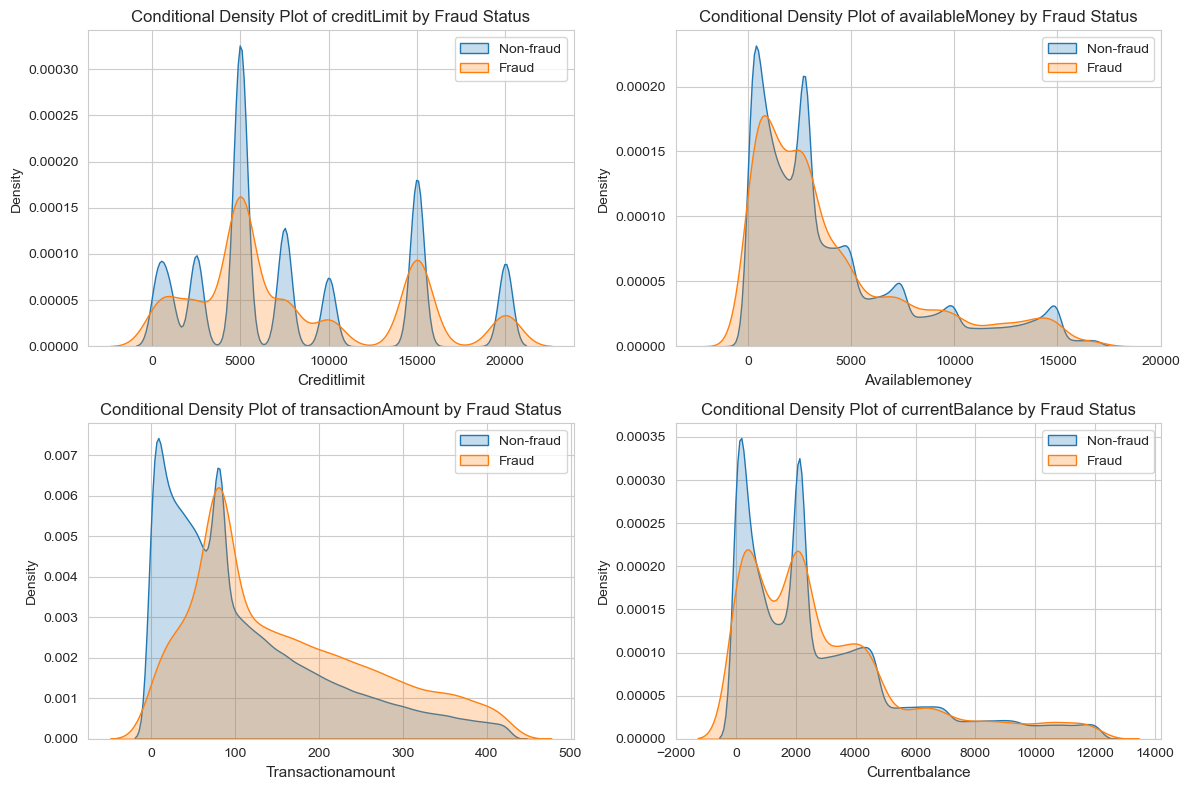

In [48]:

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i in range(2):
    for j in range(2):
        var = numerical_var[i*2+j]
        sns.kdeplot(data[data['isFraud'] == False][var], label='Non-fraud', fill=True, ax=axs[i,j])
        sns.kdeplot(data[data['isFraud'] == True][var], label='Fraud', fill=True, ax=axs[i,j])
        axs[i,j].set_xlabel(var.capitalize(), fontsize=11)
        axs[i,j].set_ylabel('Density')
        axs[i,j].set_title(f'Conditional Density Plot of {var} by Fraud Status')
        axs[i,j].legend()

plt.tight_layout()
plt.show()


The conditional plots allow us to visually compare the distributions of each numerical variable for fraud and non-fraud transactions. 

For all four plots, non-fraud transcations distribution tends to have a higher density for each numerical variable than fraud transcations, which means most of the transcations in these variables are not fraudulent.

For plots of `availableMoney`, `transactionAmount`, and `currentBalance`, we see a right skewed for both non-fraud and fraud transcations, which implies that at a lower amount of credit available money, transaction amount and current balance, there is a tendency of having more transactions.

For the plot of `transactionAmount`, the distribution for fraudulent transactions appears to be more concentrated at larger values compared to non-fraudulent transactions, which indicates that fraudulent transactions tend to involve more amounts of money when transcation amount is greater than 100.

### 11. Programmatically identify multi-swipe transactions by defining specific conditions under which they occur (e.g., same amount, within a short time span, etc.). Clearly state the conditions you have chosen for this analysis. Estimate the percentage of multi-swipe transactions and the percentage of the total dollar amount for these transactions, excluding the first "normal" transaction from the count. Discuss any interesting findings or patterns that emerge from your analysis of multi-swipe transactions and their conditions.

In [49]:
data_sorted = data.sort_values(by=['accountNumber', 'transactionDateTime'])
data_sorted1 = data_sorted.loc[:, ['accountNumber', 'transactionDateTime',
                                   'transactionAmount', 'merchantName', 'transactionType', 'isFraud']]
data_sorted1.head()

,accountNumber,transactionDateTime,transactionAmount,merchantName,transactionType,isFraud
541900,100088067,2016-01-12 00:59:52,205.13,EZ Putt Putt #982199,PURCHASE,False
541901,100088067,2016-01-12 19:49:41,46.43,Dinosaur Sandwitch Bar #303701,PURCHASE,False
541902,100088067,2016-01-17 15:41:46,378.67,Mobile eCards,PURCHASE,False
541903,100088067,2016-02-02 19:57:18,66.07,EZ Putt Putt #40513,PURCHASE,False
541904,100088067,2016-02-03 04:48:54,141.60,34th BBQ #412895,PURCHASE,False


Conditions for identifying multi-swipe transactions:
1. It has the same account number as the previous transaction.
2. The transaction amount is the same as the previous transaction.
3. The time difference between the current and previous transaction is less than or equal to 15 minutes.
4. The merchant name is the same as the previous transaction.
5. Transaction types should be the same as previous transaction, and only transaction types `unknown` and `purchase` could be identified as a multi swipe transaction.

In [50]:
multi_swipe = (
    (data_sorted1['accountNumber'] == data_sorted1['accountNumber'].shift()) &
    (data_sorted1['transactionAmount'] == data_sorted1['transactionAmount'].shift()) &
    ((data_sorted1['transactionDateTime'] - data_sorted1['transactionDateTime'].shift()).dt.total_seconds() <= 60*15) &
    (data_sorted1['merchantName'] == data_sorted1['merchantName'].shift()) &
    (data_sorted1['transactionType'].isin(['PURCHASE', 'UNKNOWN']) &
     (data_sorted1['transactionType'] == data_sorted1['transactionType'].shift()))
)


In [51]:
multi_swipe.value_counts()

False    779022
True       7341
dtype: int64

In [52]:
# percentage of multi-swipe transactions
total_trans = len(data_sorted1)
ms_trans = multi_swipe.sum()
ms__perc = (ms_trans / total_trans) * 100

print("The total number of multi-swipe transactions that we defined above is:", ms_trans)
print(f"The percentage of multi-swipe transactions that we defined above is: {ms__perc:.2f}%")


The total number of multi-swipe transactions that we defined above is: 7341
The percentage of multi-swipe transactions that we defined above is: 0.93%


In [53]:
# the percentage of the total dollar amount for multi-swipe transactions
total_dollar = data_sorted1['transactionAmount'].sum()
ms_tm= data_sorted1.loc[multi_swipe, 'transactionAmount'].sum()
ms_tm_perc = (ms_tm / total_dollar) * 100

print("The total dollar amount for multi-swipe transactions that we defined above is:", ms_tm)
print(f"The percentage of total dollar amount for multi-swipe transactions that we defined above is: {ms_tm_perc:.2f}%")


The total dollar amount for multi-swipe transactions that we defined above is: 884421.74
The percentage of total dollar amount for multi-swipe transactions that we defined above is: 1.01%


In [54]:
data_sorted1.head()

,accountNumber,transactionDateTime,transactionAmount,merchantName,transactionType,isFraud
541900,100088067,2016-01-12 00:59:52,205.13,EZ Putt Putt #982199,PURCHASE,False
541901,100088067,2016-01-12 19:49:41,46.43,Dinosaur Sandwitch Bar #303701,PURCHASE,False
541902,100088067,2016-01-17 15:41:46,378.67,Mobile eCards,PURCHASE,False
541903,100088067,2016-02-02 19:57:18,66.07,EZ Putt Putt #40513,PURCHASE,False
541904,100088067,2016-02-03 04:48:54,141.60,34th BBQ #412895,PURCHASE,False


Adding multi swipe transcation as a binary class to our dataset, since it may contribute information about fraud transaction.

In [55]:
data_sorted1['multi_swipe'] = multi_swipe
data['multi_swipe'] = data_sorted1['multi_swipe']
data['multi_swipe'].value_counts()

False    779022
True       7341
Name: multi_swipe, dtype: int64

### 12. Examine the class imbalance in the `isFraud` outcome variable and discuss the potential implications of these patterns for the development of a predictive model for credit card fraud detection. Note that at this stage, we are not building or training a predictive model. Instead, our objective is to gain a deeper understanding of the class imbalance issue in the data and explore ways to address it.

In [56]:
fraud_counts = data['isFraud'].value_counts()
fraud_perc = (fraud_counts / len(data)) * 100
fraud_counts

False    773946
True      12417
Name: isFraud, dtype: int64

In [57]:
fraud_perc

False    98.420958
True      1.579042
Name: isFraud, dtype: float64

The better choice could be using ensembling method such as random forest and boosting method, like xgboost, adaboost and etc. But for the sake of simplicity, we use random sampling method and give an example of performing under sampling method.

### 13. Implement a method of your choice to mitigate class imbalance in the isFraud outcome variable. Describe the method you used and report its effects on the class distribution. How might addressing class imbalance impact the effectiveness and performance of a predictive model for credit card fraud detection?



In [58]:
# random sampling with under sampling 
rus = RandomUnderSampler(random_state=0)
X = data.drop('isFraud', axis=1)
y = data['isFraud']
X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(False, 12417), (True, 12417)]


In [59]:
fraud_counts_u = y_resampled.value_counts()
fraud_perc_u = (fraud_counts_u / len(y_resampled)) * 100
fraud_perc_u

False    50.0
True     50.0
Name: isFraud, dtype: float64

In [60]:
# random sampling with over sampling 
ros = RandomOverSampler(random_state=0)
X_resampled_o, y_resampled_o = ros.fit_resample(X, y)
print(sorted(Counter(y_resampled_o).items()))

[(False, 773946), (True, 773946)]


In [61]:
fraud_counts_o = y_resampled_o.value_counts()
fraud_perc_o = (fraud_counts_o / len(y_resampled_o)) * 100
fraud_perc_o

False    50.0
True     50.0
Name: isFraud, dtype: float64

In [62]:
data["isFraud"].value_counts()


False    773946
True      12417
Name: isFraud, dtype: int64